In [12]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# get the df
df = pd.read_csv('aita_clean.csv')

# reduce it
reduced_df = df[['title', 'body', 'is_asshole']]

/Users/lexingtonwhalen/anaconda3/envs/cs7641_proj/lib/python3.9/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [13]:
reduced_df.head(3)

,title,body,is_asshole
0,[AITA] I wrote an explanation in TIL and came ...,[Here is the post in question](http://www.redd...,1
1,[AITA] Threw my parent's donuts away,"My parents are diabetic, morbidly obese, and a...",1
2,I told a goth girl she looked like a clown.,I was four.,0


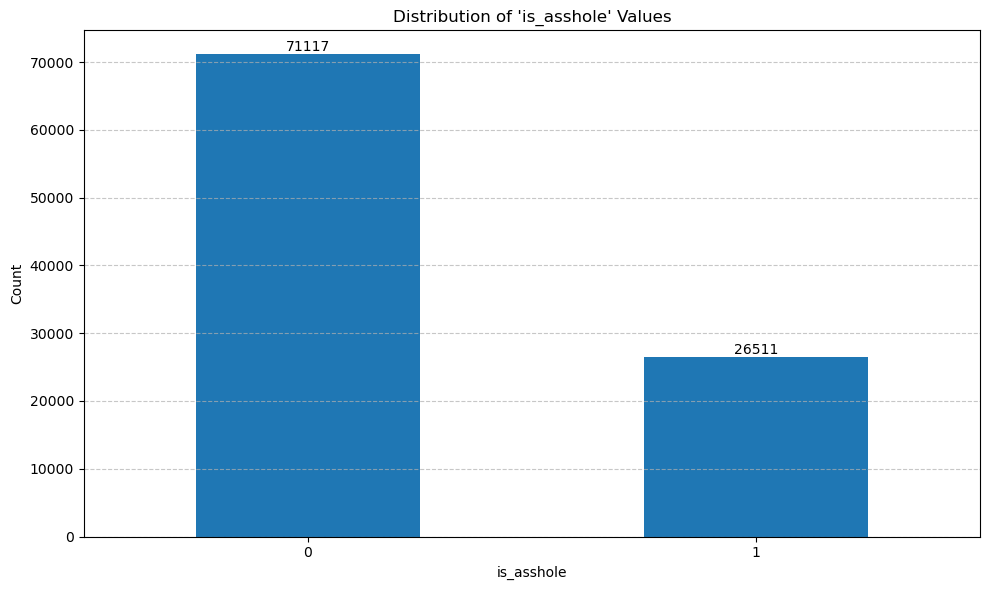

In [14]:
# Count the occurrences of each value in the 'is_asshole' column
asshole_counts = df['is_asshole'].value_counts()

# Create a bar chart
plt.figure(figsize=(10, 6))
asshole_counts.plot(kind='bar')

# Customize the chart
plt.title("Distribution of 'is_asshole' Values")
plt.xlabel("is_asshole")
plt.ylabel("Count")

# Add value labels on top of each bar
for i, v in enumerate(asshole_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=0)

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
# Initialize the SentenceTransformer model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the titles
title_embeddings = model.encode(df['title'].tolist())

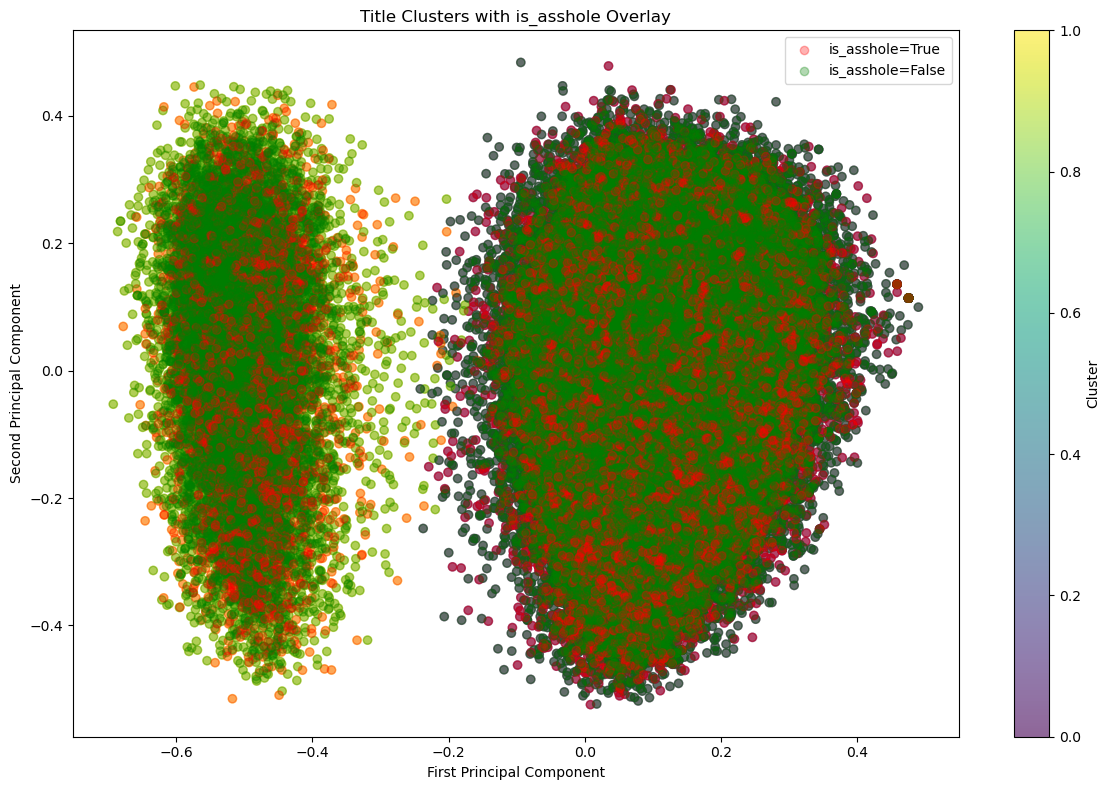

Cluster 0:
  Total posts: 80642
  Asshole ratio: 0.28
  Sample titles:
[AITA] I wrote an explanation in TIL and came o...
              [AITA] Threw my parent's donuts away
[AItA]: Argument I had with another redditor in...
[AITA] I let my story get a little long and bor...
AITA Had a disagreement about Les Miserables wi...

Cluster 1:
  Total posts: 16986
  Asshole ratio: 0.25
  Sample titles:
       I told a goth girl she looked like a clown.
              Talking about Guinea Worms in /r/WTF
Argument with a friend via text message (may be...
Was ItA? This takes place a year ago. Me and a ...
Roommate is annoying the shit out of me and I c...



In [20]:
# after get embeddings, now can cluster

# Perform K-means clustering
n_clusters = 2  # for now try 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(title_embeddings)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(title_embeddings)

# Create a scatter plot
plt.figure(figsize=(12, 8))

# Plot points colored by cluster
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                      c=cluster_labels, cmap='viridis', alpha=0.6)

# Color the points based on 'is_asshole'
is_asshole_colors = ['red' if x else 'green' for x in df['is_asshole']]
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
            c=is_asshole_colors, alpha=0.3)

plt.title("Title Clusters with is_asshole Overlay")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

# Add a color bar for clusters
plt.colorbar(scatter, label='Cluster')

# Add a legend for is_asshole
plt.scatter([], [], c='red', alpha=0.3, label='is_asshole=True')
plt.scatter([], [], c='green', alpha=0.3, label='is_asshole=False')
plt.legend()

plt.tight_layout()
plt.show()

# Analyze cluster composition
for cluster in range(n_clusters):
    cluster_posts = df[cluster_labels == cluster]
    asshole_ratio = cluster_posts['is_asshole'].mean()
    print(f"Cluster {cluster}:")
    print(f"  Total posts: {len(cluster_posts)}")
    print(f"  Asshole ratio: {asshole_ratio:.2f}")
    print(f"  Sample titles:")
    print(cluster_posts['title'].head().to_string(index=False))
    print()

In [ ]:
# Function to load embeddings
def load_embeddings(filename='embeddings.npy'):
    print(f"Loading embeddings from {filename}")
    return np.load(filename)

In [22]:
np.save('title_embeddings.npy',title_embeddings)

In [21]:
body_embeddings = model.encode(df['body'].tolist())

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming you have already generated title_embeddings and have df['is_asshole']

# Convert embeddings to numpy array if they're not already
X = np.array(title_embeddings)
y = df['is_asshole'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_predictions)

print("Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f}")
print(classification_report(y_test, lr_predictions))

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)

print("\nRandom Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(classification_report(y_test, rf_predictions))

# Compare results
print("\nModel Comparison:")
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

if lr_accuracy > rf_accuracy:
    print("Logistic Regression performed better in this case.")
elif rf_accuracy > lr_accuracy:
    print("Random Forest performed better in this case.")
else:
    print("Both models performed equally well.")